In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
fer2013 = '../archive/fer2013.csv'
data = pd.read_csv(fer2013)

# Bildpixel und Label extrahieren
images = data['pixels'].tolist()
labels = data['emotion'].tolist()

# Bilderstring und Labelstring zu Numpy-Array
images = np.array([list(map(int, pixel.split())) for pixel in images], dtype='float32') # Datentyp zu float32 wechseln, um später Normalisierung zu ermöglichen
labels = np.array(labels)

# Pixelwerte zwischen 0 und 1 mappen (normalisieren)
images/= 255.0

# Images zu (48, 48, 1 reshapen)
images = images.reshape (-1, 48, 48, 1)

# 80% train set, 10% validation set, 10% test set
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train set shape: {X_train.shape}, {y_train.shape}')
print(f'Validation set shape: {X_val.shape}, {y_val.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')

Train set shape: (28709, 48, 48, 1), (28709,)
Validation set shape: (3589, 48, 48, 1), (3589,)
Test set shape: (3589, 48, 48, 1), (3589,)


In [3]:
# Ein CNN Model definieren (Quelle: https://www.tensorflow.org/tutorials/images/cnn)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Dense Layers hinzufügen
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7, activation='softmax')) # 7 Emotionen (softmax für mehrere klassen gut)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

Epoch 1/20
898/898 [==============================] - 40s 43ms/step - loss: 1.6122 - accuracy: 0.3667 - val_loss: 1.4363 - val_accuracy: 0.4458
Epoch 2/20
898/898 [==============================] - 33s 36ms/step - loss: 1.3497 - accuracy: 0.4863 - val_loss: 1.2916 - val_accuracy: 0.5166
Epoch 3/20
898/898 [==============================] - 33s 36ms/step - loss: 1.2330 - accuracy: 0.5313 - val_loss: 1.2451 - val_accuracy: 0.5252
Epoch 4/20
898/898 [==============================] - 33s 37ms/step - loss: 1.1532 - accuracy: 0.5627 - val_loss: 1.2163 - val_accuracy: 0.5403
Epoch 5/20
898/898 [==============================] - 33s 36ms/step - loss: 1.0820 - accuracy: 0.5944 - val_loss: 1.2330 - val_accuracy: 0.5442
Epoch 6/20
898/898 [==============================] - 33s 36ms/step - loss: 1.0212 - accuracy: 0.6173 - val_loss: 1.1699 - val_accuracy: 0.5678
Epoch 7/20
898/898 [==============================] - 33s 37ms/step - loss: 0.9565 - accuracy: 0.6454 - val_loss: 1.1963 - val_accuracy:

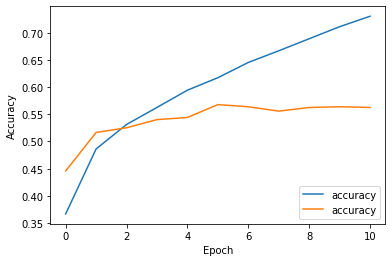

In [4]:
# Model compilen (early stopping quelle: https://keras.io/api/callbacks/early_stopping/)
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Early Stopping - verhindert Overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modell trainen
history = model.fit(X_train, y_train,
                   epochs=20,
                   validation_data= (X_val, y_val),
                   callbacks=[early_stopping])

# Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Training history plotten
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [5]:
# Ergebnisse sind okay, aber man kann das Model noch optimieren.
# Hier speichern wir jetzt das trainierte Modell damit wir es später laden können.
model.save('emotion_model.h5') # Für MacOS
model.save('emotion_model.keras') # Für Windows
